In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [3]:
# Load the preprocessed dataset
print("Loading dataset...")
preprocessed_dataset = pd.read_csv('/content/drive/MyDrive/dataset/preprocessed_battery_data.csv')

Loading dataset...


In [4]:
print(preprocessed_dataset.shape)

(8766, 8)


In [5]:
# Separate features and target
features = preprocessed_dataset.drop('SOH', axis=1)
target = preprocessed_dataset['SOH']

In [6]:
print(features.shape)
print(target.shape)

(8766, 7)
(8766,)


In [7]:
# Scale the data
feature_scaler = MinMaxScaler(feature_range=(-1, 1))
target_scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the features and target
X = feature_scaler.fit_transform(features)
y = target_scaler.fit_transform(target.values.reshape(-1, 1))

In [8]:
# Split the data with better ratios
train_ratio, val_ratio = 0.8, 0.1  # Increased training data
train_size = int(len(preprocessed_dataset) * train_ratio)
val_size = int(len(preprocessed_dataset) * val_ratio)

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]


In [9]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7012, 7)
(878, 7)
(876, 7)


In [10]:
# TimeseriesGenerator configuration
time_steps = 90  # Increased time steps
batch_size = 64  # Increased batch size

train_generator = TimeseriesGenerator(
    X_train, y_train,
    length=time_steps,
    batch_size=batch_size,
    shuffle=True
)

val_generator = TimeseriesGenerator(
    X_val, y_val,
    length=time_steps,
    batch_size=batch_size,
    shuffle=False
)

test_generator = TimeseriesGenerator(
    X_test, y_test,
    length=time_steps,
    batch_size=batch_size,
    shuffle=False
)

In [11]:
# Improved model architecture
model = Sequential([
    Input(shape=(time_steps, X_train.shape[1])),
    LSTM(128, return_sequences=False),
    Dense(1)
])

In [12]:
# Compile with custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mae', optimizer=optimizer)

# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
]


In [13]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


109/109 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.1796 - val_loss: 0.3902 - learning_rate: 0.0010
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - loss: 0.0329 - val_loss: 0.3410 - learning_rate: 0.0010
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - loss: 0.0223 - val_loss: 0.3277 - learning_rate: 0.0010
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - loss: 0.0186 - val_loss: 0.3220 - learning_rate: 0.0010
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 0.0145 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 0.0147 - val_loss: 0.2990 - learning_rate: 0.0010
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - loss: 0.0136 - val_loss: 0.2968 - learning_rate: 0.0010
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - loss: 0.0175 - val_loss: 0.2982 - learning_rate: 0.0010
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 159ms/step - loss: 0.0122 - val_loss: 0.2834 - learning_rate: 0

In [16]:
# Evaluate the model
test_loss = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.6781
Test Loss: 0.7559904456138611


In [20]:
# Make predictions
predictions = model.predict(test_generator)
predictions = predictions.reshape(-1)  # Reshape to 1D array
y_test_plot = y_test[time_steps:]  # Adjust test data to match predictions length

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_plot, predictions))
mae = mean_absolute_error(y_test_plot, predictions)
r2 = r2_score(y_test_plot, predictions)


# Print the metrics with formatting
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared Score (R²): {r2:.4f}")



13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Root Mean Square Error (RMSE): 0.7642
Mean Absolute Error (MAE): 0.7560
R-squared Score (R²): -4.6024


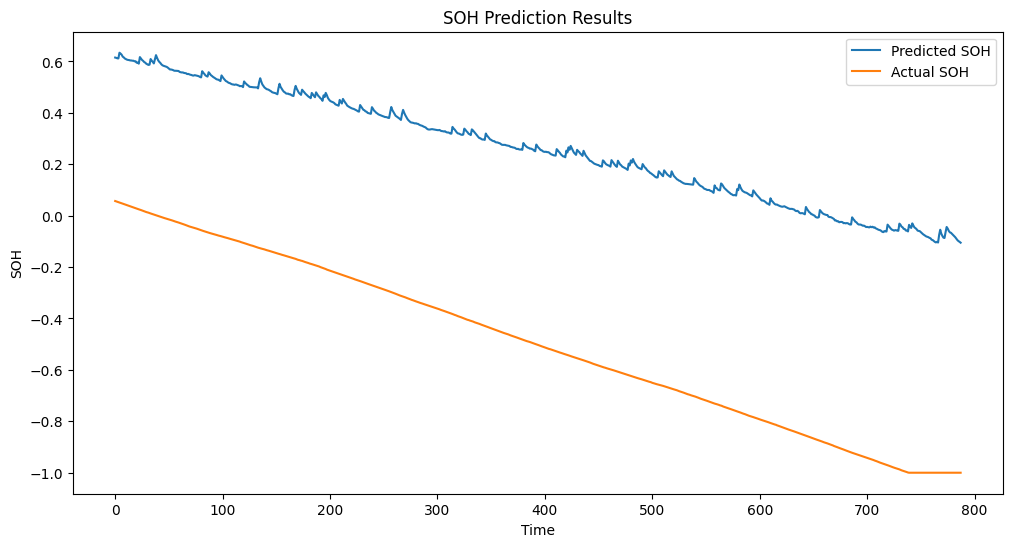

In [21]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(predictions, label='Predicted SOH')
plt.plot(y_test_plot, label='Actual SOH')
plt.title('SOH Prediction Results')
plt.xlabel('Time')
plt.ylabel('SOH')
plt.legend()
plt.show()